In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [165]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [23]:
!tar -xf lfw.tgz

In [25]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
import uuid

In [66]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # to collect 250x250px image
    frame = frame[120:120+250, 180:180+250, :]
    
    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid4())), frame)
    
    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid4())), frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(350) 
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\ad2b2d12-4453-4444-b8da-dfa9e0eb7a7b.jpg'


In [8]:
# write a prepocessing function
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) # reading an image
    img = tf.io.decode_jpeg(byte_img) #decoding the image
    img = tf.image.resize(img, (105, 105)) # resizing the image
    img = img  / 255.0 #scale image to be between 0 and 1
    return img

In [9]:
img_received = preprocess('data\\anchor\\89e74651-1b0b-49c8-a0c9-d86cf1a577aa.jpg')

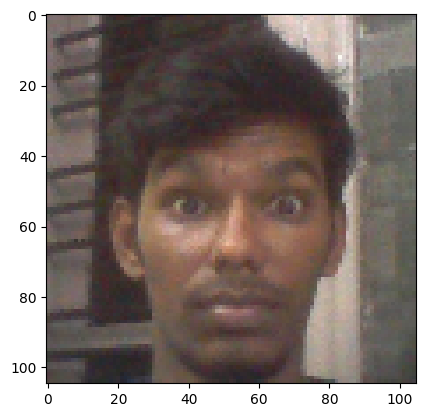

In [10]:
plt.imshow(img_received)

In [11]:
img_received.numpy().min()

0.1046419

In [ ]:
# (anchor, positives) => 1, 1, 1, 1, 1
# (anchor, negatives) => 0, 0, 0, 0, 0

In [12]:
#create labelled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
example = data.as_numpy_iterator().next()

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [16]:
res = preprocess_twin(*example)
type(res)

tuple

In [17]:
#build data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [107]:
#training partition 
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [143]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [21]:
#build embedding layer
def make_embedding():
    inp = Input(shape=(105, 105, 3), name="input_image")
    
    #first block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    #second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    #third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    #final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding' )

In [109]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [110]:
#build L1 distance layer 
class L1Dist(Layer):#synatx for python inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [111]:
def make_siamese_model():
    
    #Handle inputs
    input_image = Input(shape=(105, 105, 3), name='input_image')#anchor image
    validation_image = Input(shape=(105, 105, 3), name='validation_image')#validation image
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classificaton layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [113]:
siamese_model = make_siamese_model()

In [114]:
#setup loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [115]:
#establish checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [144]:
#build train step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        
        x = batch[:2]
        
        y = batch[2]
        
        yhat = siamese_model(x, training=True)
        
        loss = binary_cross_loss(y, yhat)
        
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [145]:
#build training loop
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
         progbar = tf.keras.utils.Progbar(len(data))
        
        #Loop through each batch
         for idx, batch in enumerate(data):
            #Running the train step here
             train_step(batch)
             progbar.update(idx+1)
            
         if epoch%5 == 0:
             checkpoint.save(file_prefix=checkpoint_prefix)

In [122]:
EPOCHS = 50

train(train_data, EPOCHS)

In [146]:
#Evaluating model

#import metric calculations
from tensorflow.keras.metrics import Precision, Recall

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]


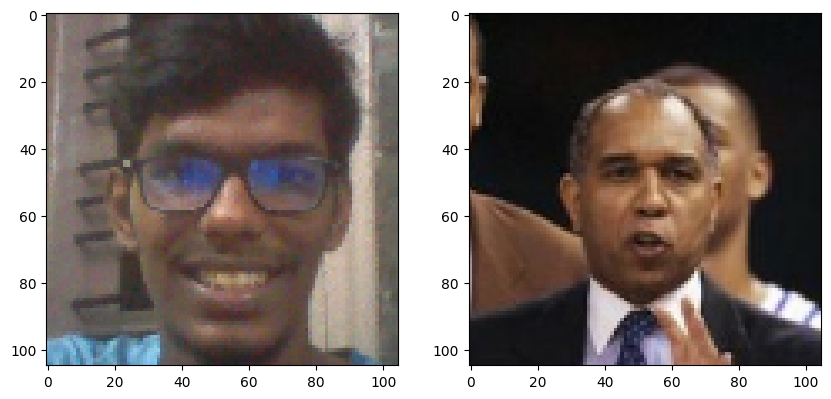

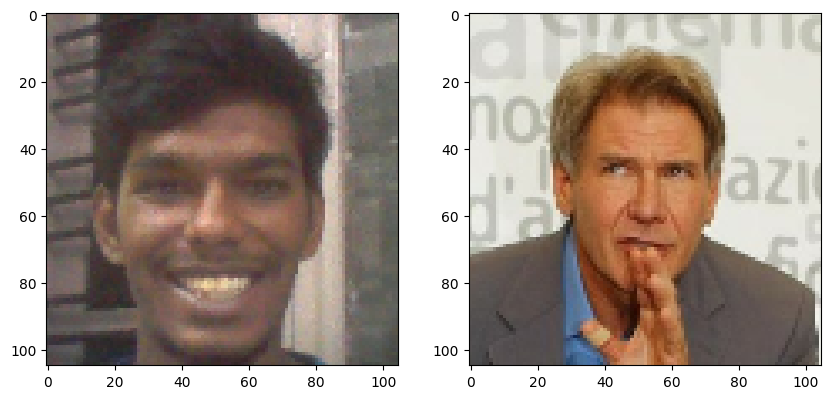

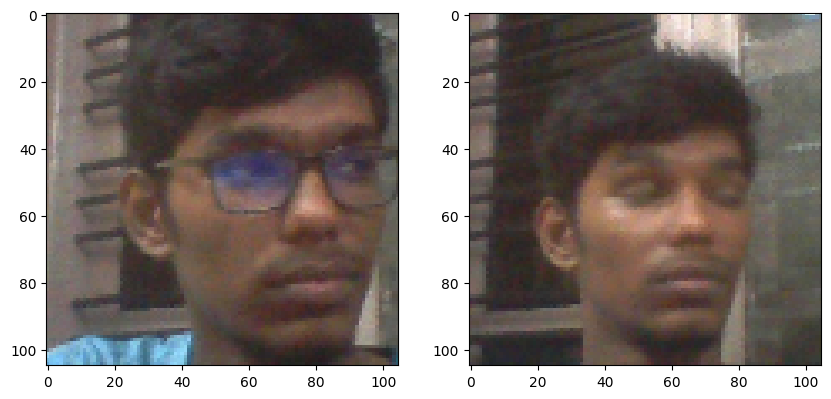

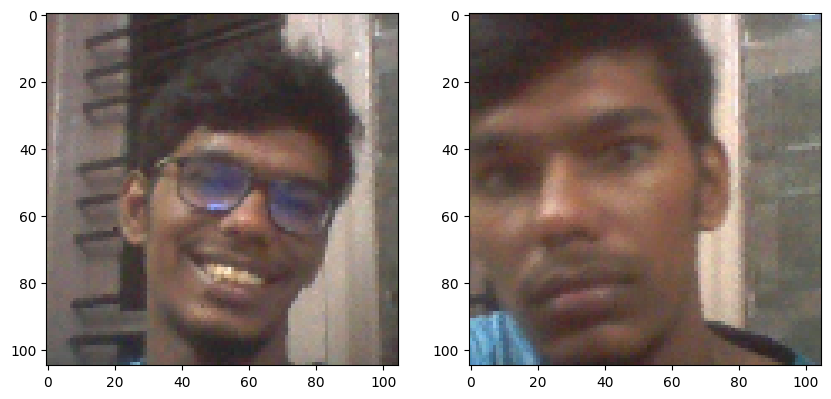

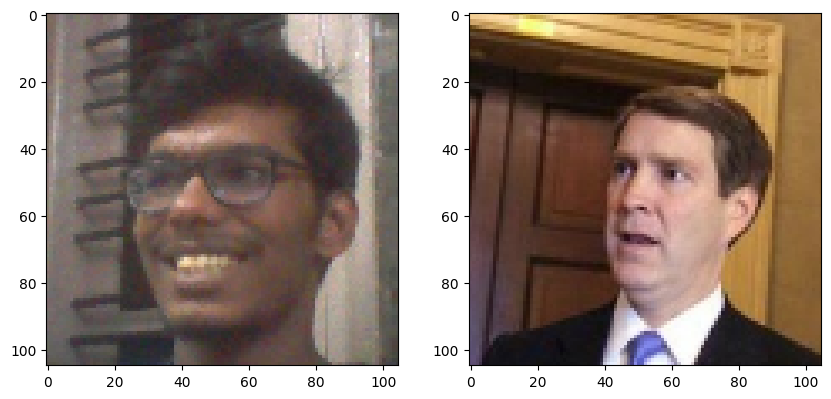

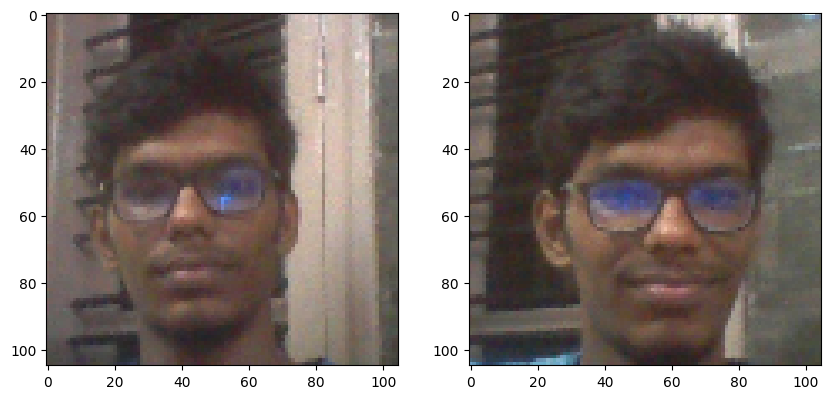

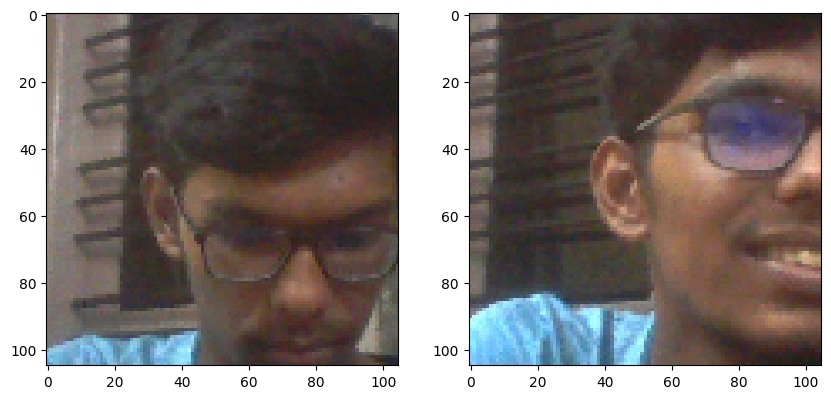

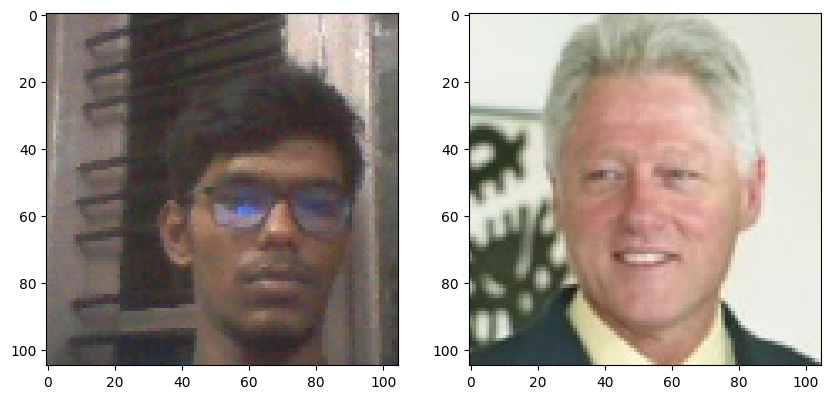

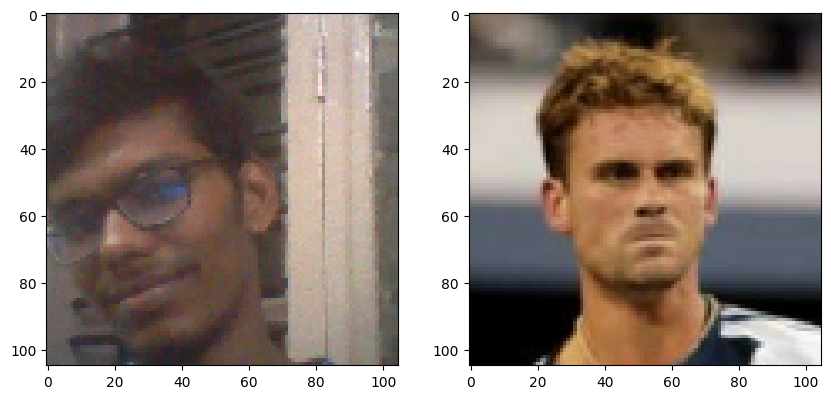

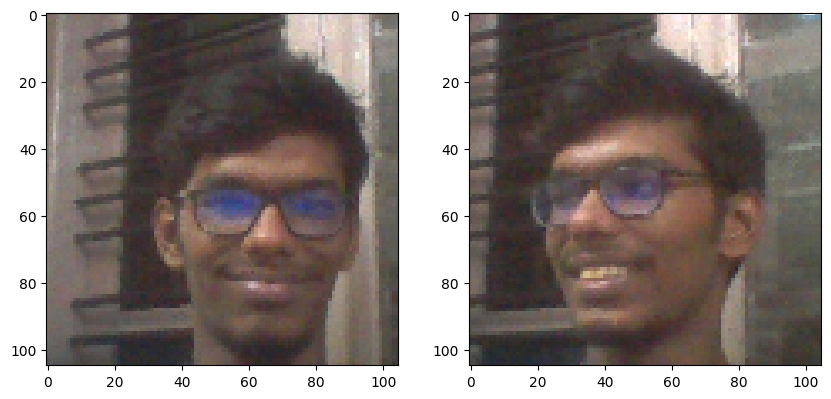

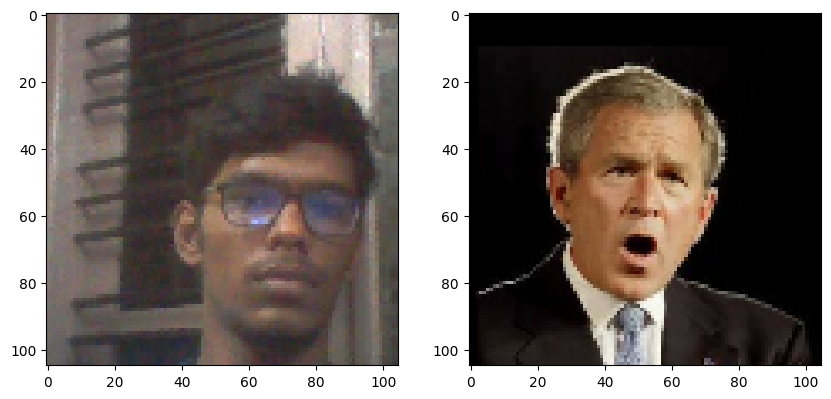

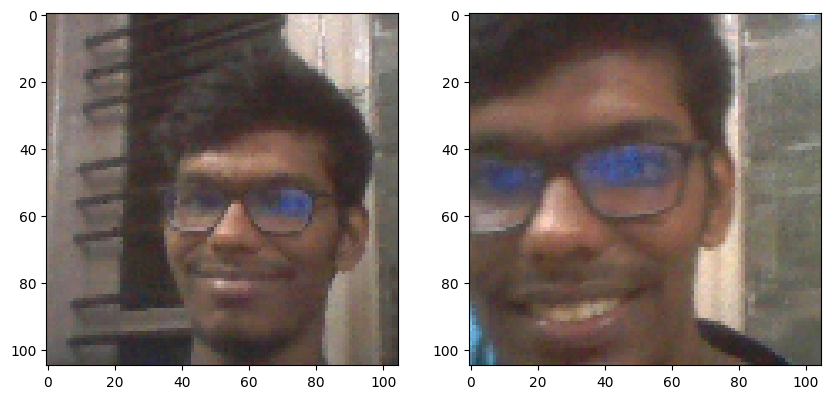

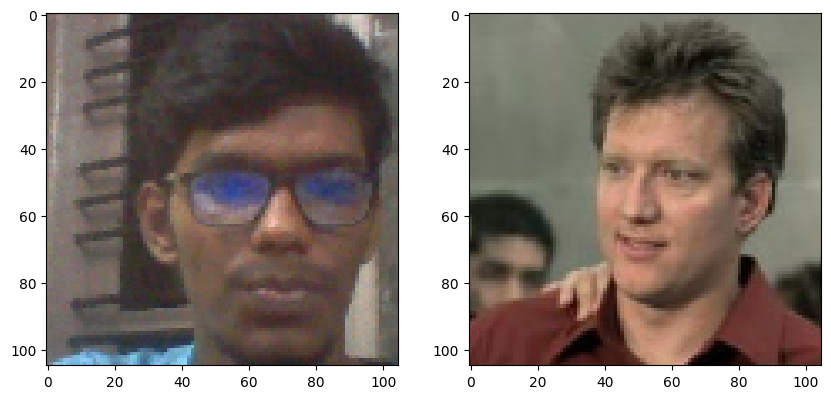

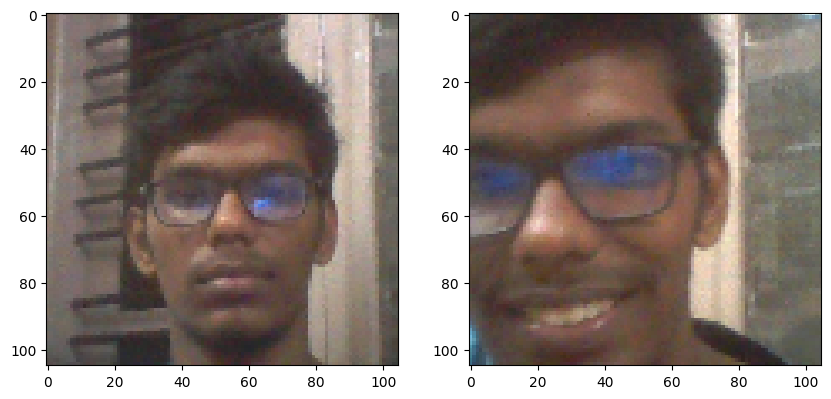

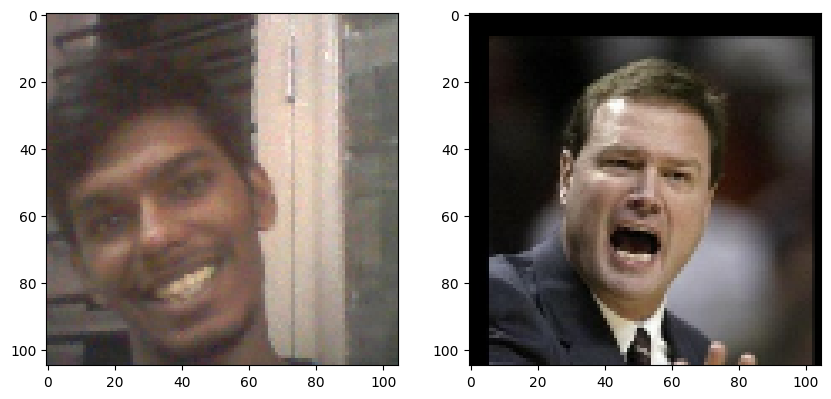

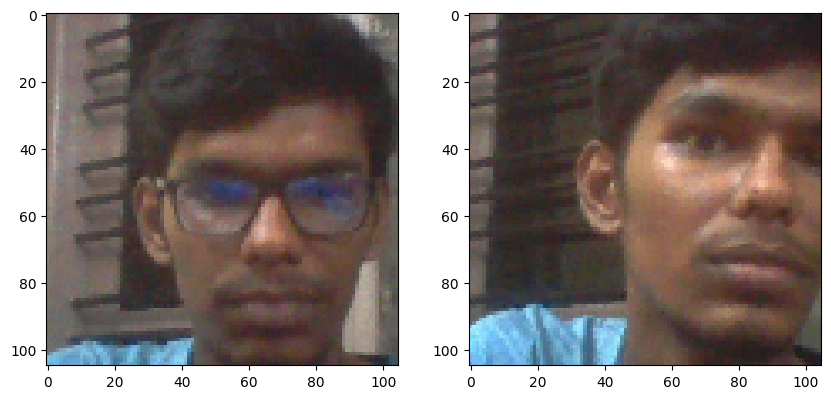

In [147]:
for x in test_data.as_numpy_iterator():
    test_ip, test_val, y_true = x[0], x[1], x[2] #obtains one batch of data
    y_hat = siamese_model.predict([test_ip, test_val]) #calculates the efficiency of prediction
    a = [1 if prediction > 0.5 else 0 for prediction in y_hat]#post processing the results
    print(a)
    m, n = Precision(), Recall() #creating objects of metric
    m.update_state(y_true, y_hat), n.update_state(y_true, y_hat) #updates the state of metrics
    #print(m.result().numpy(), n.result().numpy()) #prints the result of updates metric ojects
    
    for i in range(len(a)):
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(test_ip[i])
        plt.subplot(1, 2, 2)
        plt.imshow(test_val[i])
        plt.show()
    break

In [149]:
#save weights
siamese_model.save('siamesemodel.h5')

In [150]:
model = tf.keras.models.load_model('siamesemodel.h5', compile = False, custom_objects={'L1Dist':L1Dist, 'BinaryCrossntropy':tf.losses.BinaryCrossentropy})

In [151]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('app_data', 'verification_images')):
        ip_img = preprocess(os.path.join('app_data', 'input_images', 'input_image.jpg'))
        val_img = preprocess(os.path.join('app_data', 'verification_images', image))
        
        
        result = model.predict(list(np.expand_dims([ip_img, val_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('app_data', 'verification_images')))
    verified = verification > verification_threshold
    
    print(verification)
    
    return results, verified
    

In [50]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('app_data', 'input_images', 'input_image.jpg'), frame)
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [163]:
res, ver = verify(model, 0.5, 0.7)
print(ver)

0.75
True


In [164]:
np.sum(np.squeeze(res) > 0.9)

15